# Feature Extraction and Modeling

# General Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import os
import sklearn.model_selection as model_selection
import sklearn.linear_model as linear_model
import subprocess
from tqdm import tqdm
from PIL import Image
from sklearn.decomposition import PCA, KernelPCA

from sklearn.neural_network import MLPClassifier

from methods import (
    get_labels,
    ImageHeuristicFeatureExtractor,
    standardize_features,
    ImageDataset,
    merge_features_with_labels,
    not_oversampled_images,
    calculate_test_size,
    plot_confusion_matrix,
    plot_low_dim_components,
)

from data_augmentation import split_data_and_oversample

from sklearn.preprocessing import StandardScaler
from sklearn import svm

from sklearn.manifold import TSNE
import shap


%load_ext autoreload
%autoreload 2

In [2]:
# load repo and
repo_dir = (
    subprocess.Popen(["git", "rev-parse", "--show-toplevel"], stdout=subprocess.PIPE)
    .communicate()[0]
    .rstrip()
    .decode("utf-8")
)

# Set the folder containing the raw images
# original_folder_path = os.path.join(repo_dir, "dataverse_files/HAM10000_images_part_1")
original_folder_path = os.path.join(
    repo_dir, "dataverse_files/HAM10000_images_part_1_2_3"
)
# original_folder_path = os.path.join(repo_dir, "dataverse_files/JS_Selection")

# Create Folders
features_folder_path = os.path.join(repo_dir, "features_extracted")
processed_folder_path = os.path.join(repo_dir, "preprocessed_images")
figures_folder_path = os.path.join(repo_dir, "figures")
os.makedirs(processed_folder_path, exist_ok=True)
os.makedirs(features_folder_path, exist_ok=True)

# get pandas dataframe
label = get_labels(repo_dir)

# Load old features (or write new features using this name)
cnn_features_path = os.path.join(features_folder_path, "features.json")

TRAIN_SIZE = 0.8
OVERSAMPLE = True  #  if set to false will not oversample the minority class

if "oversampled" in cnn_features_path and OVERSAMPLE:
    data_folder_path = processed_folder_path
else:
    data_folder_path = original_folder_path

# Oversampling

In [ ]:
TRAIN_SIZE = 0.8
OVERSAMPLE = True  #  if set to false will not oversample the minority class

try:
    split_data_and_oversample(
        original_folder_path,
        processed_folder_path,
        label,
        TRAIN_SIZE,
        oversample=OVERSAMPLE,
        move_picture_up_levels=2,
    )
except OSError as e:
    print(e)
    assert False, "delete the Folder 'preprocessed_images' and try again"

# Feature Extraction

## (A) Feature Exctraction using ResNet50 (CNN)

In [ ]:
# Using the RestNet 50 model to extract features using pretrained weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize(232),
        transforms.CenterCrop(450),  # adapted to use larger region
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
dataset = ImageDataset(directory=data_folder_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
# Determine the best available device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

In [ ]:
if not os.path.exists(cnn_features_path):
    model = model.to(device)  # Move your model to the appropriate device
    model.eval()  # Set the model to evaluation mode

    features_map2 = {}
    with torch.no_grad():
        for batch_idx, (key, images) in enumerate(tqdm(data_loader)):
            images = images.to(device)  # Move images to the appropriate device

            batch_features = model(images)
            batch_features = batch_features.view(
                batch_features.size(0), -1
            )  # Flatten features

            batch_features = (
                batch_features.cpu().numpy()
            )  # Move features to CPU for numpy conversion

            for i, feature in enumerate(batch_features):
                image_id = (
                    batch_idx * data_loader.batch_size + i
                )  # Compute global image ID/index
                features_map2[key[i]] = feature

    # Saving the raw features
    features_df = pd.DataFrame(features_map2)
    features_df.to_json(cnn_features_path)
else:
    print(f"Previously computed features used: {cnn_features_path}")

### Load CNN Features (also previously generated)

In [ ]:
# load features + combine the features with labels dataframe
cnn_features = merge_features_with_labels(
    features_path=cnn_features_path,
    labels_df=label,
    export=True,
)

## (B) Heuristic Feature Extraction
Attention! The order of the features using the CNN and this Class is not necessarily the same!

In [ ]:
extractor = ImageHeuristicFeatureExtractor(
    data_folder_path, label.set_index("image_id")
)

feature_label_data = extractor.get_feature_and_label_arrays()
df_heuristic = (
    extractor.return_one_df()
)  # effectively dummy df with the filenames and image ids

x_rgb, y_rgb = feature_label_data["rgb"]
x_hsv, y_hsv = feature_label_data["hsv"]
x_glcm, y_glcm = feature_label_data["glcm"]
# x_gabor, y_gabor = feature_label_data['gabor']

In [ ]:
x_rgb_standardized = standardize_features(x_rgb, use_pca=True, n_components=0.9)
x_hsv_stanardized = standardize_features(x_hsv, use_pca=True, n_components=0.9)

x_heuristic = np.concatenate((x_rgb_standardized, x_hsv_stanardized, x_glcm), axis=1)
y_heuristic = y_hsv
np.shape(x_heuristic)

In [ ]:
names_heuristic_features = []

for i in range(len(x_rgb_standardized[0])):
    names_heuristic_features.append(f"rgb{i}")

for i in range(len(x_hsv_stanardized[0])):
    names_heuristic_features.append(f"hsv{i}")

for i in range(len(x_glcm[0])):
    names_heuristic_features.append(f"glcm{i}")

len(names_heuristic_features)

In [ ]:
np.save(os.path.join(features_folder_path, "x_heuristic"), x_heuristic)
np.save(os.path.join(features_folder_path, "y_heuristic"), y_heuristic)
np.save(
    os.path.join(features_folder_path, "names_heuristic_features"),
    names_heuristic_features,
)
df_heuristic.to_csv(os.path.join(features_folder_path, "df_heuristic"), index=True)

In [ ]:
x_heuristic = np.load(os.path.join(features_folder_path, "x_heuristic.npy"))
y_heuristic = np.load(os.path.join(features_folder_path, "y_heuristic.npy"))
names_heuristic_features = np.load(
    os.path.join(features_folder_path, "names_heuristic_features.npy")
)
df_heuristic = pd.read_csv(
    os.path.join(features_folder_path, "df_heuristic"), index_col=0
)

# Modeling

## Generate the Train and Test Split

In [ ]:
# Define which x and y to use

# CNN:
x = cnn_features.iloc[:, :1000].to_numpy()
y = cnn_features["cancer"].to_numpy()
df_ = cnn_features

# Heuristic
"""
x = x_heuristic
y = y_heuristic
df_ = df_heuristic
np.shape(x)
"""

In [ ]:
df_

In [ ]:
# only include those files in testing that have not been oversampled
include_in_testing = not_oversampled_images(df_)

TEST_SIZE = 0.30

# Calculate the adjusted test size
test_size_sklearn = calculate_test_size(df_, TEST_SIZE, include_in_testing)

x_train_, x_test, y_train_, y_test = model_selection.train_test_split(
    x[include_in_testing], y[include_in_testing], test_size=test_size_sklearn
)
x_train = np.concatenate((x_train_, x[np.invert(include_in_testing)]), axis=0)
y_train = np.concatenate((y_train_, y[np.invert(include_in_testing)]), axis=0)

In [ ]:
print(
    f"{len(y_test)} Unique Images used Test Set: {len(y_test) / len(np.unique(df_.image_id)) * 100:.2f}%"
)
print(f"{len(y_train)} Non-Unique Images used Train Set")

## Dimensionality Reduction
### PCA

In [ ]:
# Initialize PCA,
pca = PCA(n_components=0.999)

# Fit and transform the data
pca.fit(np.concatenate((x_train, x_test), axis=0))
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# Check the new shape of the data
print(x_train_pca.shape)

In [ ]:
plot_low_dim_components(x_train_pca, y_train, component_1=0, component_2=1)

### Kernel PCA (slow)

In [ ]:
# Initialize PCA,
kpca = KernelPCA(n_components=25, kernel="rbf")  # kernel: rbf, sigmoid

# Fit and transform the data
kpca.fit(np.concatenate((x_train, x_test), axis=0))
x_train_kpca = kpca.transform(x_train)
x_test_kpca = kpca.transform(x_test)

# Check the new shape of the data
print(x_train_kpca.shape)

In [ ]:
plot_low_dim_components(x_train_kpca, y_train, label="kPCA")

### t-SNE (Visualisation *only*)

In [ ]:
# Set the parameters for t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=15, n_iter=2000, verbose=1)

# Perform t-SNE on the data
X_tsne = tsne.fit_transform(np.concatenate((x_train, x_test), axis=0))

In [ ]:
plot_low_dim_components(
    X_tsne, np.concatenate((y_train, y_test), axis=0), label="t-SNE"
)

### Use Lower Dimensional Features?

In [ ]:
x_train = x_train  # x_train #x_train_kpca #x_train_pca
x_test = x_test  # x_test #x_test_kpca#x_test_pca

## LogisticRegression

In [ ]:
prediction_model = linear_model.LogisticRegression(
    solver="newton-cg", multi_class="auto", max_iter=5000, class_weight="balanced"
)

prediction_model.fit(x_train, y_train)

y_train_pred = prediction_model.predict(x_train)
y_pred = prediction_model.predict(x_test)
# plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_pred)

## SVM

In [ ]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

# Create an SVM classifier
prediction_model = svm.SVC(
    kernel="poly",
    C=1.0,
    gamma=0.5,
    class_weight="balanced",
)

# Train the classifier
prediction_model.fit(x_train, y_train)

# Make predictions
y_pred = prediction_model.predict(x_test)
plot_confusion_matrix(y_test, y_pred)

## MLPClassifier

In [ ]:
# solvers = ["lbfgs", "sgd", "adam"]
prediction_model = MLPClassifier(
    hidden_layer_sizes=[400] * 4,
    random_state=1,
    verbose=0,
    solver="adam",
    learning_rate="adaptive",
)
prediction_model.fit(x_train, y_train)
y_pred = prediction_model.predict(x_test)
plot_confusion_matrix(y_test, y_pred, True)

## SHAP Values
Not too sure how helpful this is. But we can can see how much individual features are influencing the result

In [ ]:
# Create the SHAP Explainer

# Without names
explainer = shap.Explainer(prediction_model.predict, x_train, max_evals=2500, verbose=1)

# With names (only defined for heuristic model)
# explainer = shap.Explainer(prediction_model.predict, x_train, max_evals=2500, verbose=1, feature_names=names_heuristic_features)

shap_values = explainer(x_test)

In [ ]:
fig = plt.figure()
shap.summary_plot(shap_values, x_test)

# Save the current figure
save_path = os.path.join(features_folder_path, "shap_values.png")
fig.savefig(save_path, dpi=150, bbox_inches="tight")

# End to End RestNet(Training and Testing)

### Setup

In [7]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False

num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

### Setup DataLoader

In [8]:
# Criterion (Loss function)
criterion = nn.CrossEntropyLoss()

# Optimizer (Only train the final layer)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
df_img_labels = pd.DataFrame(label[["image_id", "cancer"]])
df_img_labels["result"] = df_img_labels["cancer"].apply(
    lambda x: 0 if x == False else 1
)
df_img_labels

,image_id,cancer,result
0,ISIC_0027419,False,0
1,ISIC_0025030,False,0
2,ISIC_0026769,False,0
3,ISIC_0025661,False,0
4,ISIC_0031633,False,0
...,...,...,...
1506,ISIC_0036060,False,0
1507,ISIC_0036061,False,0
1508,ISIC_0036062,True,1
1509,ISIC_0036063,False,0


## Setup

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): DataFrame containing image IDs and labels.
            img_dir (str): Directory where images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image_id = self.img_labels.iloc[idx, 0]
        img_path = os.path.join(
            self.img_dir, self.img_labels.iloc[idx, 0] + ".jpg"
        )  # Assuming images are .jpg
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        return image, label

In [14]:
original_folder_path = data_folder_path
transform = transforms.Compose(
    [
        transforms.Resize(232),
        transforms.CenterCrop(450),  # adapted to use larger region
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
dataset = CustomImageDataset(dataframe=df_img_labels, img_dir=original_folder_path, transform=transform)

### Splitting Data

In [15]:
from torch.utils.data import random_split

total_size = len(dataset)
test_size = int(0.2 * total_size)
train_size = total_size - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Training and Testing

In [19]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

model.to(device)

num_epochs = 25  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_corrects = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item() * inputs.size(0)
        train_corrects += torch.sum(preds == labels.data)
        # print(f'Loss: {loss.item()}')

    train_loss /= len(train_loader.dataset)
    train_acc = train_corrects.float() / len(train_loader.dataset)

    # Print training results
    print(
        f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}"
    )

    # Evaluation loop
model.eval()  # Set model to evaluate mode
all_test_preds = []
all_test_labels = []
test_loss = 0.0
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())
        # Statistics
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

test_loss /= len(test_loader.dataset)
test_acc = test_corrects.float() / len(test_loader.dataset)

Using device: mps
Epoch 1/25 - Loss: 0.3160, Acc: 0.8485
Epoch 2/25 - Loss: 0.3135, Acc: 0.8533
Epoch 3/25 - Loss: 0.3093, Acc: 0.8581
Epoch 4/25 - Loss: 0.3056, Acc: 0.8563
Epoch 5/25 - Loss: 0.3054, Acc: 0.8590
Epoch 6/25 - Loss: 0.3034, Acc: 0.8602
Epoch 7/25 - Loss: 0.3008, Acc: 0.8603
Epoch 8/25 - Loss: 0.3071, Acc: 0.8567
Epoch 9/25 - Loss: 0.3005, Acc: 0.8629
Epoch 10/25 - Loss: 0.3012, Acc: 0.8592
Epoch 11/25 - Loss: 0.2945, Acc: 0.8651
Epoch 12/25 - Loss: 0.2948, Acc: 0.8681
Epoch 13/25 - Loss: 0.2971, Acc: 0.8635
Epoch 14/25 - Loss: 0.2932, Acc: 0.8653
Epoch 15/25 - Loss: 0.2949, Acc: 0.8655
Epoch 16/25 - Loss: 0.2949, Acc: 0.8712
Epoch 17/25 - Loss: 0.2925, Acc: 0.8688
Epoch 18/25 - Loss: 0.2904, Acc: 0.8689
Epoch 19/25 - Loss: 0.2901, Acc: 0.8694
Epoch 20/25 - Loss: 0.2890, Acc: 0.8688
Epoch 21/25 - Loss: 0.2857, Acc: 0.8721
Epoch 22/25 - Loss: 0.2918, Acc: 0.8675
Epoch 23/25 - Loss: 0.2875, Acc: 0.8701
Epoch 24/25 - Loss: 0.2816, Acc: 0.8712
Epoch 25/25 - Loss: 0.2869, Acc

Accuracy: 0.8542299349240781
Precision: 0.731404958677686
Recall: 0.3950892857142857
F1 Score: 0.5130434782608696


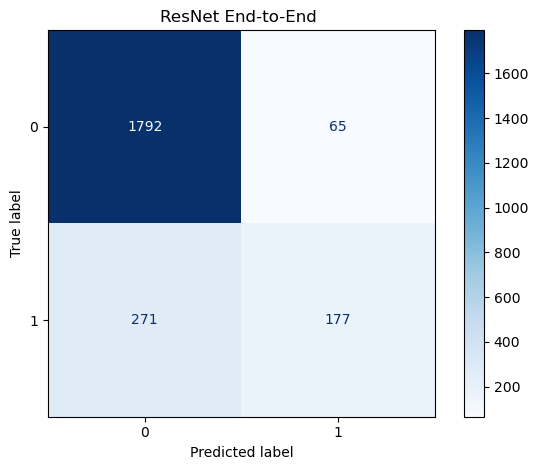

In [20]:
cf = plot_confusion_matrix(all_test_labels, all_test_preds, return_fig=True)
fig = cf.figure_
plt.gca().set_title("ResNet End-to-End ")
fig.tight_layout()
fig.savefig(figures_folder_path + "/resnet_end_to_end.pdf")